# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
sent_0 = soup.get_text()
print(sent_0)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
sent_1000 = soup.get_text()
print(sent_1000)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
sent_1500 = soup.get_text()
print(sent_1500)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
sent_4900 = soup.get_text()
print(sent_4900)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"wont","will not",phrase) # in some words aposthepe is missing
    phrase = re.sub(r"its","it is",phrase)
    phrase = re.sub(r"Its","It is",phrase)
    phrase = re.sub(r"isnt","is not",phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_0 = decontracted(sent_0)
print(sent_0)
print("="*50)

My dogs loves this chicken but it is a product from China, so we will not be buying it anymore.  It is very hard to find any chicken products made in the USA but they are out there, but this one is not.  It is too bad too because it is a good product but I will not take any chances till they know what is going on with the china imports.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_4900 = re.sub("\S*\d\S*", "", sent_4900).strip()
print(sent_4900)

For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first start by saying that everyone is looking for something different for their ideal tea, and I will attempt to briefly highlight what makes this tea attractive to a wide range of tea drinkers (whether you are a beginner or long-time tea enthusiast).  I have gone through over  boxes of this tea myself, and highly recommend it for the following reasons:-Quality:  First, this tea offers a smooth quality without any harsh or bitter after tones, which often turns people off from many green teas.  I've found my ideal brewing time to be between  minutes, giving you a light but flavorful cup of tea.  However, if you get distracted or forget about your tea and leave it brewing for  minutes like I sometimes do, the quality of this tea is such that you still get a smooth but deeper flavor without the bad after taste.  The leaves themselves are whole leaves (not powdered stems, b

In [20]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

For those of you wanting a high quality yet affordable green tea you should definitely give this one a try Let me first start by saying that everyone is looking for something different for their ideal tea and I will attempt to briefly highlight what makes this tea attractive to a wide range of tea drinkers whether you are a beginner or long time tea enthusiast I have gone through over boxes of this tea myself and highly recommend it for the following reasons Quality First this tea offers a smooth quality without any harsh or bitter after tones which often turns people off from many green teas I ve found my ideal brewing time to be between minutes giving you a light but flavorful cup of tea However if you get distracted or forget about your tea and leave it brewing for minutes like I sometimes do the quality of this tea is such that you still get a smooth but deeper flavor without the bad after taste The leaves themselves are whole leaves not powdered stems branches etc commonly found i

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
import itertools
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    
    #https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/
    # This removes words such as aawwww or happpyyy or awsooommmee etc
    sentence = ''.join(''.join(s)[:2] for _, s in itertools.groupby(sentence))
    
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:36<00:00, 1271.93it/s]


In [23]:
smpl = " aaaaww aaaww aaa aawwww"
sent = ''.join(''.join(s)[:2] for _, s in itertools.groupby(smpl))
print(sent)

 aaww aaww aa aaww


In [24]:
preprocessed_reviews[4900]

'wanting high quality yet affordable green tea definitely give one try let first start saying everyone looking something different ideal tea attempt briefly highlight makes tea attractive wide range tea drinkers whether beginner long time tea enthusiast gone boxes tea highly recommend following reasons quality first tea offers smooth quality without harsh bitter tones often turns people many green teas found ideal brewing time minutes giving light flavorful cup tea however get distracted forget tea leave brewing minutes like sometimes quality tea still get smooth deeper flavor without bad taste leaves whole leaves not powdered stems branches etc commonly found brands high quality nylon bags also include chunks tropical fruit discernible ingredients not standard cheap paper bag mix unknown ingredients ground fine powder leaving wonder actually drinking taste tea offers notes real pineapple hints tropical fruit yet not sweet artificially flavored foundation high quality young hyson green

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly performing preprocessing for review summary also.

preprocessed_summary=[]

for sent in tqdm(final['Summary'].values):
    sent = re.sub(r"http\S+","",sent)
    sent = BeautifulSoup(sent,'lxml').get_text()
    sent = decontracted(sent)
    sent = re.sub(r"\S+\d\S+","",sent).strip()
    sent = re.sub(r"[^A-Za-z0]+"," ",sent)
    
    #https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/
    # This removes words such as aawwww or happpyyy or awsooommmee etc
    sent = ''.join(''.join(s)[:2] for _, s in itertools.groupby(sent))
    
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(w.lower() for w in sent.split() if w.lower() not in stopwords)
    preprocessed_summary.append(sent.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:17<00:00, 2563.52it/s]


In [26]:
preprocessed_summary[4900]

'truly well balanced green tea'

In [27]:
final['Summary'].values[4900]

'A Truly Well-Balanced Green Tea'

In [28]:
# Removing those words which are of lenght 2
# This will remove non relevant words then we will perform featurization
cleaned_reviews = []
for sent in tqdm(preprocessed_reviews):
    sentence = ' '.join(w for w in sent.split() if len(w)>2)
    cleaned_reviews.append(sentence.strip())

100%|█████████████████████████████████████████████████████████████████████████| 46071/46071 [00:00<00:00, 69422.22it/s]


In [29]:
print(cleaned_reviews[0])

dogs loves chicken product china not buying anymore hard find chicken products made usa one not bad good product not take chances till know going china imports


In [30]:
final["Cleaned_review"] = cleaned_reviews
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_review
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china not buying an...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons not beat great pr...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


# [4] Featurization

## [4.1] BAG OF WORDS

In [31]:
#BoW
count_vect1 = CountVectorizer() #in scikit-learn
count_vect1.fit(cleaned_reviews)
print("some feature names ", count_vect1.get_feature_names()[:10])
print('='*50)

final_counts = count_vect1.transform(cleaned_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aaa', 'aaah', 'aaahh', 'aaaww', 'aachen', 'aadp', 'aaf', 'aafco', 'aah', 'aahhs']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 38772)
the number of unique words  38772


## [4.2] Bi-Grams and n-Grams.

In [33]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect2 = CountVectorizer(ngram_range=(1,2), min_df=5)
final_bigram_counts = count_vect2.fit_transform(cleaned_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
bigram_features = count_vect2.get_feature_names()
print(bigram_features[:10])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 59655)
the number of unique words including both unigrams and bigrams  59655
['aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'ability buy', 'able', 'able add', 'able afford']


## [4.3] TF-IDF

In [34]:
# tfidf on unigrams
tf_idf_vect1 = TfidfVectorizer()
tf_idf_vect1.fit(cleaned_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect1.get_feature_names()[0:10])
print('='*50)

final_tf_idf1 = tf_idf_vect1.transform(cleaned_reviews)
print("the type of count vectorizer ",type(final_tf_idf1))
print("the shape of out text TFIDF vectorizer ",final_tf_idf1.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf1.get_shape()[1])

some sample features(unique words in the corpus) ['aaa', 'aaah', 'aaahh', 'aaaww', 'aachen', 'aadp', 'aaf', 'aafco', 'aah', 'aahhs']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 38772)
the number of unique words including both unigrams and bigrams  38772


In [38]:
# Tfidf on bigrams
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2),min_df=3)
tf_idf_vect2.fit(cleaned_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect2.get_feature_names()[0:10])
print('='*50)

final_tf_idf2 = tf_idf_vect2.transform(cleaned_reviews)
print("the type of count vectorizer ",type(final_tf_idf2))
print("the shape of out text TFIDF vectorizer ",final_tf_idf2.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf2.get_shape()[1])

some sample features(unique words in the corpus) ['aafco', 'aback', 'abandon', 'abandoned', 'abbott', 'abby', 'abc', 'abdomen', 'abdominal', 'abdominal pain']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 115699)
the number of unique words including both unigrams and bigrams  115699


## [4.4] Word2Vec

In [39]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in tqdm(cleaned_reviews):
    list_of_sentence.append(sentence.split())

100%|████████████████████████████████████████████████████████████████████████| 46071/46071 [00:00<00:00, 133611.51it/s]


In [40]:
outfile = open("list_of_sentence","wb")
pickle.dump(list_of_sentence,outfile)
outfile.close()

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb 
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v =False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=3,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8226403594017029), ('fantastic', 0.8149124979972839), ('good', 0.8089359998703003), ('terrific', 0.7827798128128052), ('excellent', 0.7694401741027832), ('amazing', 0.7551678419113159), ('wonderful', 0.7451079487800598), ('perfect', 0.7331461906433105), ('decent', 0.728928804397583), ('fabulous', 0.6842518448829651)]
[('nastiest', 0.7852265238761902), ('greatest', 0.7365906238555908), ('best', 0.7324913740158081), ('experienced', 0.710783839225769), ('tastiest', 0.7016306519508362), ('ive', 0.6797410249710083), ('hottest', 0.6664899587631226), ('smoothest', 0.6598447561264038), ('awful', 0.6534530520439148), ('blandest', 0.6448079943656921)]


In [43]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16667
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'not', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'beat', 'great', 'received', 'shipment', 'could']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [44]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [161]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(cleaned_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [142]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [47]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

46071
50


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [82]:
from sklearn.cross_validation import train_test_split

# cleaned_reviews contains all the required reviews
# Splitting cleaned_reviews into train and test dataset

X = cleaned_reviews
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train),len(Y_train),len(X_test),len(Y_test))

C:\Users\rites\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


32249 32249 13822 13822


In [84]:
# Now we will vectorize train and test datasets separately using BagofWords
# Use fit_transform to vectorize train dataset and transform to vectorize test dataset
count_vect2 = CountVectorizer()
X_train = count_vect2.fit_transform(X_train)
X_test = count_vect2.transform(X_test)
print(X_train.shape,X_test.shape)

(32249, 32938) (13822, 32938)


In [89]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Time series object
tscv = TimeSeriesSplit(n_splits=10)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

param_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
acc_list = []
auc_list = []

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='brute',leaf_size=30)
    i=0
    acc=0.0
    auc=0.0
    for train_index,test_index in tscv.split(X_train):
        x_train = X_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = X_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_y = clf.predict(x_test)
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        acc += accuracy_score(y_test,predict_y,normalize=True) * float(100)
        auc += roc_auc_score(y_test,predict_probab)
    
    acc_list.append(acc)
    auc_list.append(auc)
    print("Cross Validation Accuracy for k = {:d} is {:.2f}% and auc is {:.2f}".format(k,acc/i,auc/i))
        
        

Cross Validation Accuracy for k = 1 is 77.87% and auc is 0.58
Cross Validation Accuracy for k = 3 is 82.47% and auc is 0.62
Cross Validation Accuracy for k = 5 is 83.00% and auc is 0.64
Cross Validation Accuracy for k = 7 is 83.24% and auc is 0.64
Cross Validation Accuracy for k = 9 is 83.40% and auc is 0.65
Cross Validation Accuracy for k = 11 is 83.30% and auc is 0.66
Cross Validation Accuracy for k = 13 is 83.28% and auc is 0.66
Cross Validation Accuracy for k = 15 is 83.30% and auc is 0.66
Cross Validation Accuracy for k = 17 is 83.33% and auc is 0.66
Cross Validation Accuracy for k = 19 is 83.32% and auc is 0.66
Cross Validation Accuracy for k = 21 is 83.33% and auc is 0.66
Cross Validation Accuracy for k = 23 is 83.37% and auc is 0.67
Cross Validation Accuracy for k = 25 is 83.37% and auc is 0.67
Cross Validation Accuracy for k = 27 is 83.40% and auc is 0.68
Cross Validation Accuracy for k = 29 is 83.39% and auc is 0.68


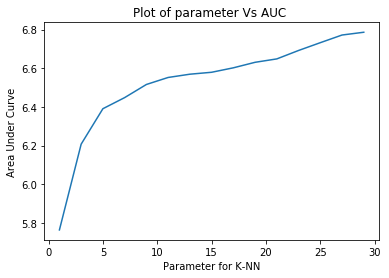

In [90]:
import matplotlib.pyplot as plt

# Plotting graph of auc and parameter

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Area Under Curve")
plt.title("Plot of parameter Vs AUC ")
plt.show()

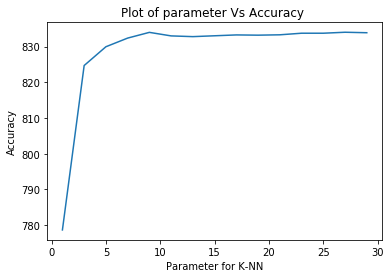

In [91]:

# Plotting graph of accuracy and parameter

plt.plot(param_list,acc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Accuracy")
plt.title("Plot of parameter Vs Accuracy ")
plt.show()

In [92]:
# Training final model on best auc and taking k = 21

final_clf = KNeighborsClassifier(n_neighbors=21,algorithm='brute',leaf_size=30)

final_clf.fit(X_train,Y_train)

predict_y = final_clf.predict(X_test)
predict_probab = final_clf.predict_proba(X_test)[:,1] # This returns only probability of +ve class 

acc = accuracy_score(Y_test,predict_y,normalize=True)* float(100)
auc = roc_auc_score(Y_test,predict_probab)
print("Final Accuracy is {:.2f}% and auc is {:.2f}".format(acc,auc))


Final Accuracy is 84.05% and auc is 0.67


In [53]:
outfile = open("BOW_burte","wb")
pickle.dump(final_clf,outfile)
outfile.close()

In [79]:
# Plotting confusion matrix of this model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix_plot(y_test,predict_y):
    C = confusion_matrix(y_test,predict_y) # This matrix contains true +ve , false +ve , true -ve and false -ve
    
    # Calculating precision matrix
    
    P = (C/C.sum(axis=0)) 
    # Explaination 
    # axis = 0 will calculate sum about columns and divide each element in that column with that sum 
    # C = [1,4
    #      2,7]
    # C.sum(axis=1) is [3,11]
    # P = [1/3 , 4/11
    #      2/3 , 3/11]
    
    # Calculating recall matrix
    
    R = (((C.T)/(C.sum(axis=1))).T)
    # Explaination
    # axis = 1 will calculate sum about rows and divide all the elements in that row with that sum.
    # C = [1 , 4
    #      2 , 7]
    # C.T will be [1 , 2
    #              4 , 7]
    # C.sum(axis=0) is [5,9]
    # (C.T)/(C.sum(axis=1)) will be [1/5 , 4/5
    #                                2/9 , 7/9]
    
    labels = [0,1] # This list contains class labels
    
    # cmap object which contains color code
    cmap = sns.light_palette("orange")
    
    #Plotting confusion matrix
    print("=========== Confusion matrix ==========")
    plt.figure(figsize=(4,4))
    sns.heatmap(C,annot=True,cmap=cmap,fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    
    # Plotting Precision confusion matrix
    print("=========== Precision Matrix ==========")
    plt.figure(figsize=(4,4))
    sns.heatmap(P,annot=True,cmap=cmap,fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    
    # Plotting Recall Matrix
    print("=========== Recall Matrix =============")
    plt.figure(figsize=(4,4))
    sns.heatmap(R,annot=True,cmap=cmap,fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()
    

=========== Confusion matrix ==========


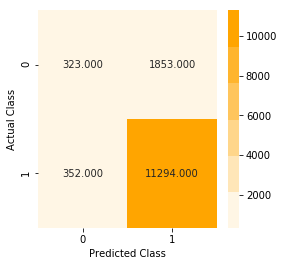

=========== Precision Matrix ==========


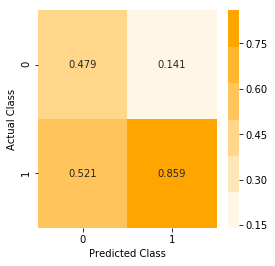

=========== Recall Matrix =============


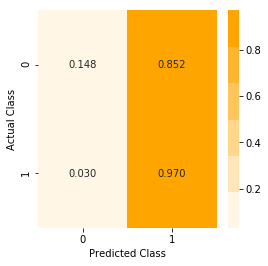

In [93]:
# Calling confusion_matrix_plot

confusion_matrix_plot(Y_test,predict_y)

In [94]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,predict_y))

             precision    recall  f1-score   support

          0       0.48      0.15      0.23      2176
          1       0.86      0.97      0.91     11646

avg / total       0.80      0.84      0.80     13822



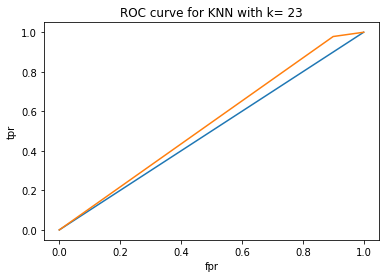

In [58]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(Y_test,predict_y)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve for KNN with k= 23")
plt.show()

In [59]:
# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

Area under ROC curve is =0.620 


# Observations

#### 1. Precision and recall for +ve class is good but for -ve class is very bad .

### [5.1.2] Applying KNN brute force on TFIDF

In [109]:
# In this section Tfidf will be used for vectorization
# Splitting datasets into train and test datasets

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

# Now we will vectorize train and test datasets separately using Tfidf 
# Use fit_transform to vectorize train dataset and transform to vectorize test dataset
X_train = tf_idf_vect2.fit_transform(X_train)
X_test = tf_idf_vect2.transform(X_test)

In [111]:
# Performing time series split cross validation

acc_list=[]
auc_list=[]

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='brute',leaf_size=30)
    i=0
    acc=0.0
    auc=0.0
    for train_index,test_index in tscv.split(X_train):
        x_train = X_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = X_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_y = clf.predict(x_test)
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        acc += accuracy_score(y_test,predict_y,normalize=True) * float(100)
        auc += roc_auc_score(y_test,predict_probab)
    
    
    auc_list.append(auc)
    acc_list.append(acc)
    print("Cross Validation Accuracy for k = {:d} is {:.2f}% and auc is {:.2f}".format(k,acc/i,auc/i))
        

Cross Validation Accuracy for k = 1 is 83.24% and auc is 0.50
Cross Validation Accuracy for k = 3 is 83.23% and auc is 0.50
Cross Validation Accuracy for k = 5 is 83.19% and auc is 0.51
Cross Validation Accuracy for k = 7 is 83.22% and auc is 0.52
Cross Validation Accuracy for k = 9 is 83.24% and auc is 0.52
Cross Validation Accuracy for k = 11 is 83.24% and auc is 0.53
Cross Validation Accuracy for k = 13 is 83.25% and auc is 0.53
Cross Validation Accuracy for k = 15 is 83.28% and auc is 0.53
Cross Validation Accuracy for k = 17 is 83.27% and auc is 0.55
Cross Validation Accuracy for k = 19 is 83.27% and auc is 0.56
Cross Validation Accuracy for k = 21 is 83.28% and auc is 0.56
Cross Validation Accuracy for k = 23 is 83.27% and auc is 0.58
Cross Validation Accuracy for k = 25 is 83.26% and auc is 0.59
Cross Validation Accuracy for k = 27 is 83.25% and auc is 0.60
Cross Validation Accuracy for k = 29 is 83.26% and auc is 0.60


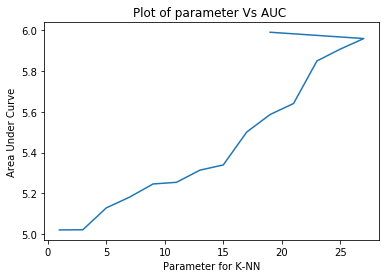

In [112]:
import matplotlib.pyplot as plt

# Plotting graph of auc and parameter

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Area Under Curve")
plt.title("Plot of parameter Vs AUC ")
plt.show()

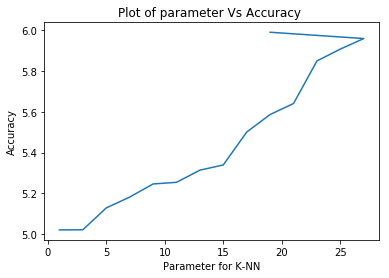

In [113]:


# Plotting graph of auc and parameter

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Accuracy")
plt.title("Plot of parameter Vs Accuracy ")
plt.show()

In [63]:
# Training final model on best auc and taking k = 25

final_clf = KNeighborsClassifier(n_neighbors=25,algorithm='brute',leaf_size=30)

final_clf.fit(X_train,Y_train)

predict_y = final_clf.predict(X_test)
predict_probab = final_clf.predict_proba(X_test)[:,1] # This returns only probability of +ve class 

acc = accuracy_score(Y_test,predict_y,normalize=True)* float(100)
auc = roc_auc_score(Y_test,predict_probab)
print("Final Accuracy is {:.2f}% and auc is {:.2f}".format(acc,auc))

#print("For k = 29 final accuracy is {:.2f}% and auc is {:.3f}%".format(acc,auc))

Final Accuracy is 84.26% and auc is 0.51


In [ ]:
outfile = open("BOW_burte","wb")
pickle.dump(final_clf,outfile)
outfile.close()

=========== Confusion matrix ==========


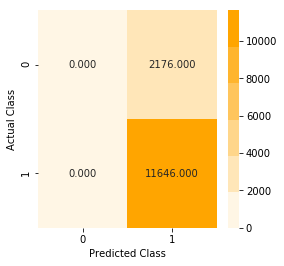

=========== Precision Matrix ==========


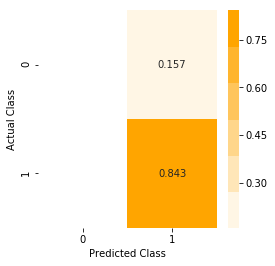

=========== Recall Matrix =============


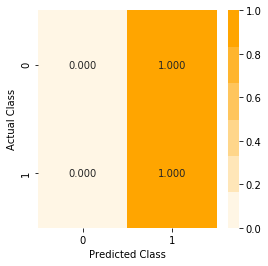

In [64]:
# Calling confusion_matrix_plot

confusion_matrix_plot(Y_test,predict_y)

In [65]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,predict_y))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2176
          1       0.84      1.00      0.91     11646

avg / total       0.71      0.84      0.77     13822



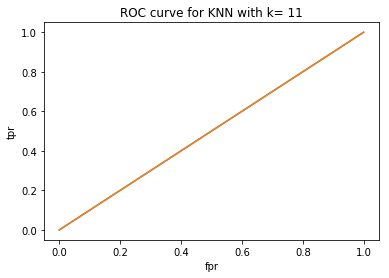

In [66]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(Y_test,predict_y)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve for KNN with k= 11")
plt.show()

In [67]:
# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

Area under ROC curve is =0.510 


### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [95]:
# In this section avg_w2v will be used for vectorization
# Splitting datasets into train and test datasets

X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentence,Y,test_size=0.3,random_state=42)
print(X_train[0])


['like', 'one', 'alot', 'literally', 'tastes', 'like', 'chocolate', 'brownie', 'nuts', 'not', 'overly', 'sweet', 'either', 'nice', 'energy', 'bar', 'work', 'healthy', 'taste', 'good', 'raw', 'completely', 'organic', 'good', 'fiber', 'protein', 'sugar', 'agave', 'nectar', 'also', 'healthy', 'alternative', 'sugars', 'definitely', 'buying', 'brand', 'trying', 'flavors']


In [96]:
# Now we will vectorize train dataset usin avg_w2v
train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

32249
50


In [97]:
# Vectorization of test dataset using avg_w2v

test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

13822
50


In [102]:
# 10 fold cross validation using time series splitting

auc_list=[]
acc_list=[]

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='brute',leaf_size=30)
    i=0
    acc=0.0
    auc=0.0
    for train_index,test_index in tscv.split(train_sent_vectors):
        x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_y = clf.predict(x_test)
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        acc += accuracy_score(y_test,predict_y,normalize=True) * float(100)
        auc += roc_auc_score(y_test,predict_probab)
    auc_list.append(auc)
    acc_list.append(acc)
    print("Cross Validation Accuracy for k = {:d} is {:.2f}% and auc is {:.2f}".format(k,acc/i,auc/i))

Cross Validation Accuracy for k = 1 is 82.09% and auc is 0.67
Cross Validation Accuracy for k = 3 is 85.13% and auc is 0.77
Cross Validation Accuracy for k = 5 is 85.80% and auc is 0.81
Cross Validation Accuracy for k = 7 is 86.30% and auc is 0.83
Cross Validation Accuracy for k = 9 is 86.54% and auc is 0.84
Cross Validation Accuracy for k = 11 is 86.58% and auc is 0.85
Cross Validation Accuracy for k = 13 is 86.59% and auc is 0.86
Cross Validation Accuracy for k = 15 is 86.67% and auc is 0.86
Cross Validation Accuracy for k = 17 is 86.71% and auc is 0.86
Cross Validation Accuracy for k = 19 is 86.73% and auc is 0.87
Cross Validation Accuracy for k = 21 is 86.72% and auc is 0.87
Cross Validation Accuracy for k = 23 is 86.70% and auc is 0.87
Cross Validation Accuracy for k = 25 is 86.69% and auc is 0.87
Cross Validation Accuracy for k = 27 is 86.62% and auc is 0.87
Cross Validation Accuracy for k = 29 is 86.65% and auc is 0.87


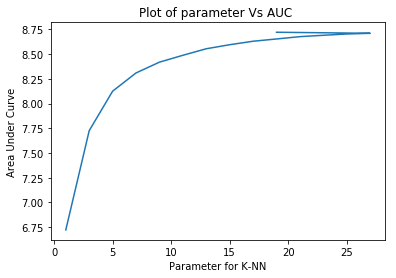

In [103]:
import matplotlib.pyplot as plt

# Plotting graph of auc and parameter

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Area Under Curve")
plt.title("Plot of parameter Vs AUC ")
plt.show()

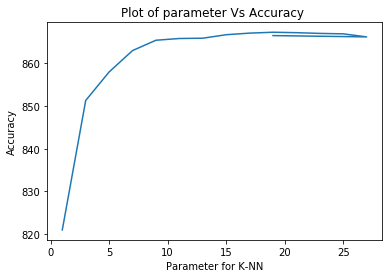

In [104]:


# Plotting graph of accuracy and parameter

plt.plot(param_list,acc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Accuracy")
plt.title("Plot of parameter Vs Accuracy ")
plt.show()

In [105]:
# Training final model on best auc and taking k = 17

final_clf = KNeighborsClassifier(n_neighbors=17,algorithm='brute',leaf_size=30)

final_clf.fit(train_sent_vectors,Y_train)

predict_y = final_clf.predict(test_sent_vectors)
predict_probab = final_clf.predict_proba(test_sent_vectors)[:,1] # This returns only probability of +ve class 

acc = accuracy_score(Y_test,predict_y,normalize=True)* float(100)
auc = roc_auc_score(Y_test,predict_probab)
print("Final Accuracy is {:.2f}% and auc is {:.2f}".format(acc,auc))

#print("For k = 29 final accuracy is {:.2f}% and auc is {:.2f}%".format(acc,auc))

Final Accuracy is 87.77% and auc is 0.87


=========== Confusion matrix ==========


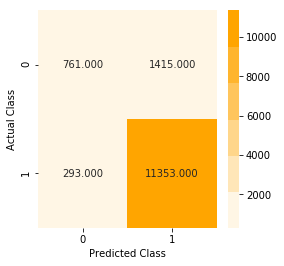

=========== Precision Matrix ==========


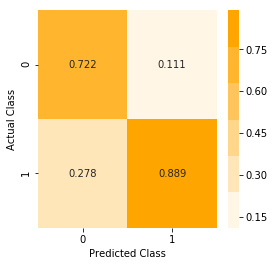

=========== Recall Matrix =============


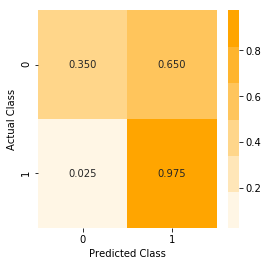

In [77]:
# Calling confusion_matrix_plot

confusion_matrix_plot(Y_test,predict_y)

In [78]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,predict_y))

             precision    recall  f1-score   support

          0       0.72      0.35      0.47      2176
          1       0.89      0.97      0.93     11646

avg / total       0.86      0.88      0.86     13822



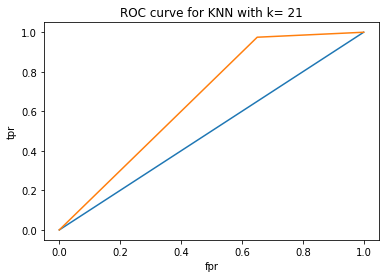

In [80]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(Y_test,predict_y)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve for KNN with k= 21")
plt.show()

In [81]:
# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

Area under ROC curve is =0.878 


### [5.1.4] Applying KNN brute force on TFIDF W2V

In [173]:
X_train,X_test,Y_train,Y_test = train_test_split(cleaned_reviews,Y,test_size=0.3,random_state=42)

In [174]:
model = TfidfVectorizer()
model.fit_transform(cleaned_reviews)
tfidf_feat = model.get_feature_names()

In [175]:
# Vectorizing train dataset

# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1


In [176]:
outfile = open("tfidf_w2v_train_vect","wb")
pickle.dump(train_tfidf_sent_vectors,outfile)
outfile.close()

In [146]:
infile = open("tfidf_w2v_train_vect","rb")
train_tfidf_sent_vectors = pickle.load(infile)
infile.close()

In [177]:
# TF-IDF weighted Word2Vec
model.fit_transform(X_test)
tfidf_feat = model.get_feature_names()
test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum +=1
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [178]:
outfile = open("tfidf_w2v_test_vect","wb")
pickle.dump(test_tfidf_sent_vectors,outfile)
outfile.close()

In [179]:
# 10 fold cross validation using time series splitting

acc_list = []
auc_list = []

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='brute',leaf_size=30)
    i=0
    acc=0.0
    auc=0.0
    for train_index,test_index in tscv.split(train_tfidf_sent_vectors):
        x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_y = clf.predict(x_test)
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        acc += accuracy_score(y_test,predict_y,normalize=True) * float(100)
        auc += roc_auc_score(y_test,predict_probab)
    
    acc_list.append(acc)
    auc_list.append(auc)
    print("Cross Validation Accuracy for k = {:d} is {:.2f}% and auc is {:.2f}".format(k,acc/i,auc/i))

Cross Validation Accuracy for k = 1 is 82.09% and auc is 0.67
Cross Validation Accuracy for k = 3 is 85.13% and auc is 0.77
Cross Validation Accuracy for k = 5 is 85.80% and auc is 0.81
Cross Validation Accuracy for k = 7 is 86.30% and auc is 0.83
Cross Validation Accuracy for k = 9 is 86.54% and auc is 0.84
Cross Validation Accuracy for k = 11 is 86.58% and auc is 0.85
Cross Validation Accuracy for k = 13 is 86.59% and auc is 0.86
Cross Validation Accuracy for k = 15 is 86.67% and auc is 0.86
Cross Validation Accuracy for k = 17 is 86.71% and auc is 0.86
Cross Validation Accuracy for k = 19 is 86.73% and auc is 0.87
Cross Validation Accuracy for k = 21 is 86.72% and auc is 0.87
Cross Validation Accuracy for k = 23 is 86.70% and auc is 0.87
Cross Validation Accuracy for k = 25 is 86.69% and auc is 0.87
Cross Validation Accuracy for k = 27 is 86.62% and auc is 0.87
Cross Validation Accuracy for k = 29 is 86.65% and auc is 0.87


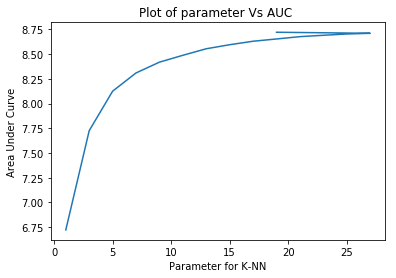

In [180]:
import matplotlib.pyplot as plt

# Plotting graph of auc and parameter

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Area Under Curve")
plt.title("Plot of parameter Vs AUC ")
plt.show()

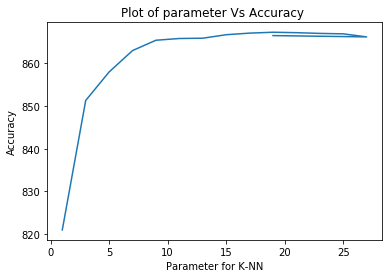

In [181]:
plt.plot(param_list,acc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Accuracy")
plt.title("Plot of parameter Vs Accuracy ")
plt.show()

In [182]:
# Training final model on best auc and taking k = 17

final_clf = KNeighborsClassifier(n_neighbors=21,algorithm='brute',leaf_size=30)

final_clf.fit(train_tfidf_sent_vectors,Y_train)

predict_y = final_clf.predict(test_tfidf_sent_vectors)
predict_probab = final_clf.predict_proba(test_tfidf_sent_vectors)[:,1] # This returns only probability of +ve class 

acc = accuracy_score(Y_test,predict_y,normalize=True)* float(100)
auc = roc_auc_score(Y_test,predict_probab)
print("Final Accuracy is {:.2f}% and auc is {:.2f}".format(acc,auc))


Final Accuracy is 84.26% and auc is 0.50


=========== Confusion matrix ==========


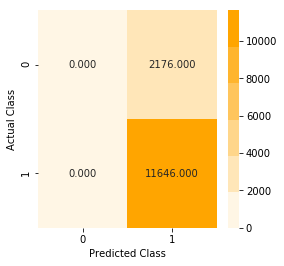

=========== Precision Matrix ==========


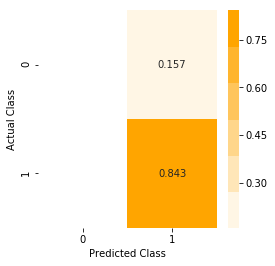

=========== Recall Matrix =============


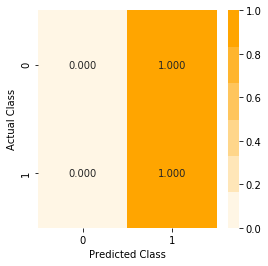

In [183]:
# Calling confusion_matrix_plot

confusion_matrix_plot(Y_test,predict_y)

In [184]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,predict_y))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2176
          1       0.84      1.00      0.91     11646

avg / total       0.71      0.84      0.77     13822



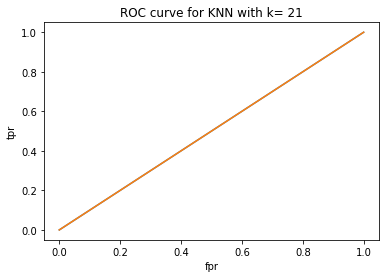

Area under ROC curve is =0.500 


In [185]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(Y_test,predict_y)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve for KNN with k= 21")
plt.show()

# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [60]:
# Kd tree works slow for high dimensional data.
# Therefore taking top 5000 features
count_vect = CountVectorizer(max_features=5000)

X = cleaned_reviews
# Splitting data into train and test dataset
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train),len(X_test))

32249 13822


In [61]:
# Vectorizing train and test dataset seperately
X_train = count_vect.fit_transform(X_train)
X_train.shape

X_test = count_vect.transform(X_test)
X_test.shape

(13822, 5000)

In [68]:
# Performing 10 fold cross validation on time split data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

param_list=[1,3,5,7,9,11,13,15,17,19,21,23,25,27,19]
auc_list = []
acc_list = []

for k in range(1,30,2):
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',leaf_size=40)
    acc = 0.0
    auc = 0.0
    i=0
    for train_index,test_index in tscv.split(X_train):
        x_train = X_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = X_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_y = clf.predict(x_test)
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        acc += accuracy_score(y_test,predict_y,normalize=True) * float(100)
        auc += roc_auc_score(y_test,predict_probab)
    
    auc_list.append(auc)
    acc_list.append(acc)
    print("Cross Validation Accuracy for k = {:d} is {:.2f}% and auc is {:.2f}".format(k,acc/i,auc/i))
    

Cross Validation Accuracy for k = 1 is 77.79% and auc is 0.58
Cross Validation Accuracy for k = 3 is 82.71% and auc is 0.63
Cross Validation Accuracy for k = 5 is 83.07% and auc is 0.65
Cross Validation Accuracy for k = 7 is 83.23% and auc is 0.65
Cross Validation Accuracy for k = 9 is 83.31% and auc is 0.66
Cross Validation Accuracy for k = 11 is 83.37% and auc is 0.66
Cross Validation Accuracy for k = 13 is 83.37% and auc is 0.67
Cross Validation Accuracy for k = 15 is 83.35% and auc is 0.67
Cross Validation Accuracy for k = 17 is 83.42% and auc is 0.67
Cross Validation Accuracy for k = 19 is 83.43% and auc is 0.67
Cross Validation Accuracy for k = 21 is 83.43% and auc is 0.68
Cross Validation Accuracy for k = 23 is 83.48% and auc is 0.68
Cross Validation Accuracy for k = 25 is 83.44% and auc is 0.68
Cross Validation Accuracy for k = 27 is 83.47% and auc is 0.69
Cross Validation Accuracy for k = 29 is 83.44% and auc is 0.69


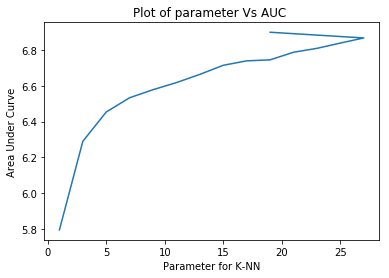

In [69]:
import matplotlib.pyplot as plt

# Plotting graph of auc and parameter

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Area Under Curve")
plt.title("Plot of parameter Vs AUC ")
plt.show()

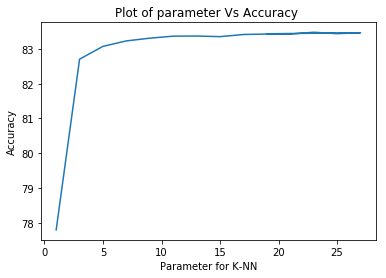

In [73]:
# Plotting graph of accuracy and parameter

acc_list = [x*10.0 for x in acc_list]

plt.plot(param_list,acc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Accuracy")
plt.title("Plot of parameter Vs Accuracy ")
plt.show()

In [75]:
# Testing final model for k = 25

final_clf = KNeighborsClassifier(n_neighbors=25,algorithm='kd_tree',leaf_size=40)
final_clf.fit(X_train,Y_train)

predict_y = final_clf.predict(X_test)
predict_probab = final_clf.predict_proba(X_test)[:,1]

acc = accuracy_score(Y_test,predict_y,normalize=True)* float(100)
auc = roc_auc_score(Y_test,predict_probab)

print("Accuracy of model for k = 25 is {:.2f} and AUC is {:.2f}".format(acc,auc))

Accuracy of model for k = 25 is 83.89 and AUC is 0.68


=========== Confusion matrix ==========


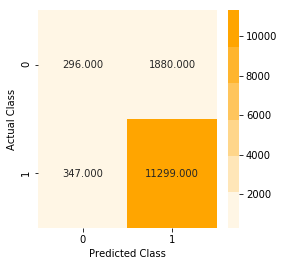

=========== Precision Matrix ==========


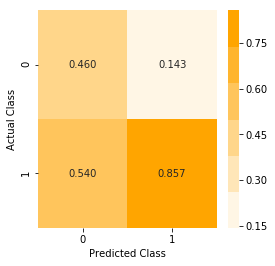

=========== Recall Matrix =============


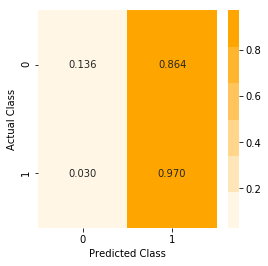

In [76]:
# Plotting confusion matrix plot
confusion_matrix_plot(Y_test,predict_y)

In [77]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,predict_y))

             precision    recall  f1-score   support

          0       0.46      0.14      0.21      2176
          1       0.86      0.97      0.91     11646

avg / total       0.79      0.84      0.80     13822



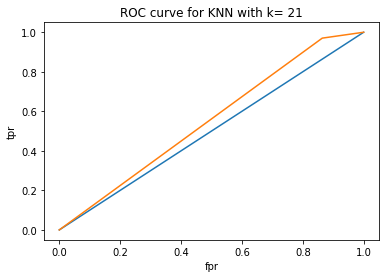

Area under ROC curve is =0.681 


In [78]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(Y_test,predict_y)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve for KNN with k= 21")
plt.show()

# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

In [79]:
# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

Area under ROC curve is =0.681 


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [80]:
# In this section Tfidf will be used for vectorization
# Splitting datasets into train and test datasets

tf_idf_vect = TfidfVectorizer(max_features=5000)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

# Now we will vectorize train and test datasets separately using Tfidf 
# Use fit_transform to vectorize train dataset and transform to vectorize test dataset
X_train = tf_idf_vect.fit_transform(X_train)
X_test = tf_idf_vect.transform(X_test)

In [87]:
# Performing 10 fold cross validation on time series split data

auc_list=[]
acc_list=[]
for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',leaf_size=40)
    i=0
    acc=0.0
    auc=0.0
    
    for train_index,test_index in tscv.split(X_train):
        x_train = X_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = X_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_y = clf.predict(x_test)
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        acc += accuracy_score(y_test,predict_y,normalize=True) * float(100)
        auc += roc_auc_score(y_test,predict_probab)
        
    auc_list.append(auc)
    acc_list.append(acc)
    
    print("Cross Validation Accuracy for k = {:d} is {:.2f}% and auc is {:.2f}".format(k,acc/i,auc/i))
        

Cross Validation Accuracy for k = 1 is 82.72% and auc is 0.51
Cross Validation Accuracy for k = 3 is 83.21% and auc is 0.51
Cross Validation Accuracy for k = 5 is 83.17% and auc is 0.52
Cross Validation Accuracy for k = 7 is 83.24% and auc is 0.53
Cross Validation Accuracy for k = 9 is 83.25% and auc is 0.53
Cross Validation Accuracy for k = 11 is 83.25% and auc is 0.53
Cross Validation Accuracy for k = 13 is 83.27% and auc is 0.53
Cross Validation Accuracy for k = 15 is 83.25% and auc is 0.53
Cross Validation Accuracy for k = 17 is 83.25% and auc is 0.55
Cross Validation Accuracy for k = 19 is 83.25% and auc is 0.56
Cross Validation Accuracy for k = 21 is 83.25% and auc is 0.56
Cross Validation Accuracy for k = 23 is 83.25% and auc is 0.58
Cross Validation Accuracy for k = 25 is 83.25% and auc is 0.59
Cross Validation Accuracy for k = 27 is 83.24% and auc is 0.59
Cross Validation Accuracy for k = 29 is 83.24% and auc is 0.60


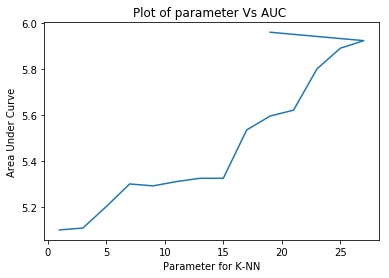

In [88]:
import matplotlib.pyplot as plt

# Plotting graph of auc and parameter

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Area Under Curve")
plt.title("Plot of parameter Vs AUC ")
plt.show()

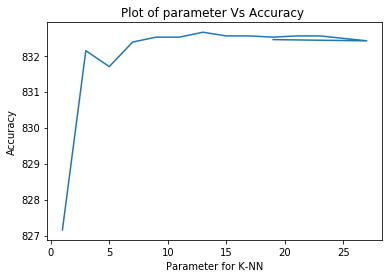

In [89]:
import matplotlib.pyplot as plt

# Plotting graph of accuracy and parameter

plt.plot(param_list,acc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Accuracy")
plt.title("Plot of parameter Vs Accuracy ")
plt.show()

In [90]:
# Training final model on best auc and taking k = 25

final_clf = KNeighborsClassifier(n_neighbors=25,algorithm='brute',leaf_size=30)

final_clf.fit(X_train,Y_train)

predict_y = final_clf.predict(X_test)
predict_probab = final_clf.predict_proba(X_test)[:,1] # This returns only probability of +ve class 

acc = accuracy_score(Y_test,predict_y,normalize=True)* float(100)
auc = roc_auc_score(Y_test,predict_probab)
print("Final Accuracy is {:.2f}% and auc is {:.2f}".format(acc,auc))

#print("For k = 25 final accuracy is {:.2f}% and auc is {:.3f}%".format(acc,auc))

Final Accuracy is 84.26% and auc is 0.53


=========== Confusion matrix ==========


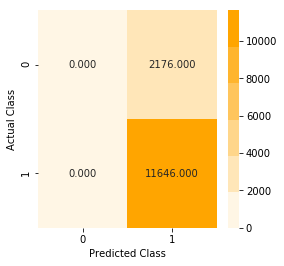

=========== Precision Matrix ==========


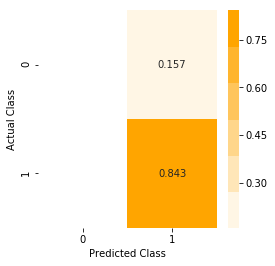

=========== Recall Matrix =============


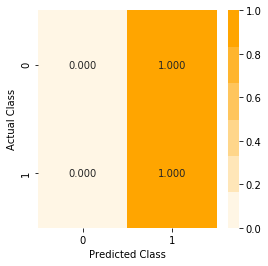

In [91]:
# Calling confusion_matrix_plot

confusion_matrix_plot(Y_test,predict_y)

In [92]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,predict_y))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2176
          1       0.84      1.00      0.91     11646

avg / total       0.71      0.84      0.77     13822



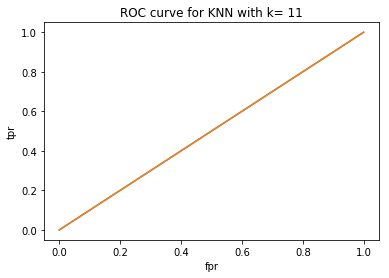

In [93]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(Y_test,predict_y)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve for KNN with k= 11")
plt.show()

In [94]:
# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

Area under ROC curve is =0.528 


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [106]:
# 10 fold cross validation using time series splitting
# Here X_train is train_sent_vectors and X_test is test_sent_vectors
# Here vectorization results of previous section is used . Only KNN algorithm is changed

auc_list=[]
acc_list=[]
for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',leaf_size=40,n_jobs=3)
    i=0
    acc=0.0
    auc=0.0
    for train_index,test_index in tscv.split(train_sent_vectors):
        x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_y = clf.predict(x_test)
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        acc += accuracy_score(y_test,predict_y,normalize=True) * float(100)
        auc += roc_auc_score(y_test,predict_probab)
    
    auc_list.append(auc)
    acc_list.append(acc)
    print("Cross Validation Accuracy for k = {:d} is {:.2f}% and auc is {:.2f}".format(k,acc/i,auc/i))

Cross Validation Accuracy for k = 1 is 82.08% and auc is 0.67
Cross Validation Accuracy for k = 3 is 85.13% and auc is 0.77
Cross Validation Accuracy for k = 5 is 85.80% and auc is 0.81
Cross Validation Accuracy for k = 7 is 86.30% and auc is 0.83
Cross Validation Accuracy for k = 9 is 86.54% and auc is 0.84
Cross Validation Accuracy for k = 11 is 86.58% and auc is 0.85
Cross Validation Accuracy for k = 13 is 86.59% and auc is 0.86
Cross Validation Accuracy for k = 15 is 86.67% and auc is 0.86
Cross Validation Accuracy for k = 17 is 86.71% and auc is 0.86
Cross Validation Accuracy for k = 19 is 86.73% and auc is 0.87
Cross Validation Accuracy for k = 21 is 86.72% and auc is 0.87
Cross Validation Accuracy for k = 23 is 86.70% and auc is 0.87
Cross Validation Accuracy for k = 25 is 86.69% and auc is 0.87
Cross Validation Accuracy for k = 27 is 86.62% and auc is 0.87
Cross Validation Accuracy for k = 29 is 86.65% and auc is 0.87


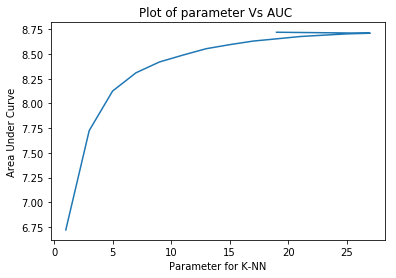

In [107]:
import matplotlib.pyplot as plt

# Plotting graph of auc and parameter

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Area Under Curve")
plt.title("Plot of parameter Vs AUC ")
plt.show()

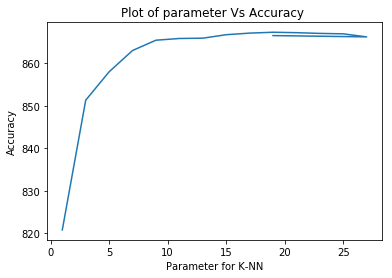

In [108]:

# Plotting graph of auc and parameter

plt.plot(param_list,acc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Accuracy")
plt.title("Plot of parameter Vs Accuracy ")
plt.show()

In [118]:
# Training the final model
final_clf = KNeighborsClassifier(n_neighbors=21,algorithm='kd_tree',leaf_size=30)

final_clf.fit(train_sent_vectors,Y_train)

predict_y = final_clf.predict(test_sent_vectors)
predict_probab = final_clf.predict_proba(test_sent_vectors)[:,1] # Returns the class probabality of +ve class only

acc = accuracy_score(Y_test,predict_y,normalize=True)*float(100)
auc = roc_auc_score(Y_test,predict_probab)

print("Accuracy of model with k = 21 is {:.2f}% and auc is {:.2f}".format(acc,auc))

Accuracy of model with k = 21 is 87.64% and auc is 0.88


=========== Confusion matrix ==========


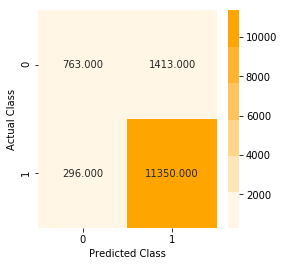

=========== Precision Matrix ==========


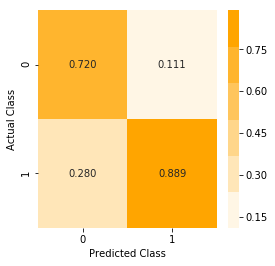

=========== Recall Matrix =============


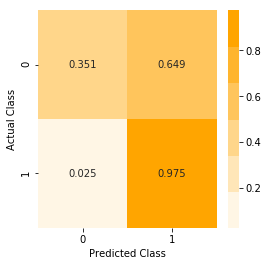

In [119]:
# Plotting confusion matrix , precision and recall matrix

confusion_matrix_plot(Y_test,predict_y)

In [120]:
# Printing the classification report
print(classification_report(Y_test,predict_y))

             precision    recall  f1-score   support

          0       0.72      0.35      0.47      2176
          1       0.89      0.97      0.93     11646

avg / total       0.86      0.88      0.86     13822



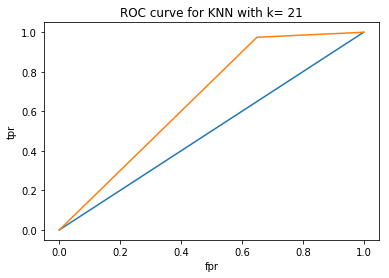

Area under ROC curve is =0.878 


In [121]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(Y_test,predict_y)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve for KNN with k= 21")
plt.show()

# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [163]:
# 10 fold cross validation on time series splitting 
# Here we are using vectorized dataset from previous section

acc_list = []
auc_list = []

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',leaf_size=40)
    i=0
    acc=0.0
    auc=0.0
    for train_index,test_index in tscv.split(train_tfidf_sent_vectors):
        x_train = train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_y = clf.predict(x_test)
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        acc += accuracy_score(y_test,predict_y,normalize=True) * float(100)
        auc += roc_auc_score(y_test,predict_probab)
    
    acc_list.append(acc)
    auc_list.append(auc)
    print("Cross Validation Accuracy for k = {:d} is {:.2f}% and auc is {:.2f}".format(k,acc/i,auc/i))

Cross Validation Accuracy for k = 1 is 82.08% and auc is 0.67
Cross Validation Accuracy for k = 3 is 85.13% and auc is 0.77
Cross Validation Accuracy for k = 5 is 85.80% and auc is 0.81
Cross Validation Accuracy for k = 7 is 86.30% and auc is 0.83
Cross Validation Accuracy for k = 9 is 86.54% and auc is 0.84
Cross Validation Accuracy for k = 11 is 86.58% and auc is 0.85
Cross Validation Accuracy for k = 13 is 86.59% and auc is 0.86
Cross Validation Accuracy for k = 15 is 86.67% and auc is 0.86
Cross Validation Accuracy for k = 17 is 86.71% and auc is 0.86
Cross Validation Accuracy for k = 19 is 86.73% and auc is 0.87
Cross Validation Accuracy for k = 21 is 86.72% and auc is 0.87
Cross Validation Accuracy for k = 23 is 86.70% and auc is 0.87
Cross Validation Accuracy for k = 25 is 86.69% and auc is 0.87
Cross Validation Accuracy for k = 27 is 86.62% and auc is 0.87
Cross Validation Accuracy for k = 29 is 86.65% and auc is 0.87


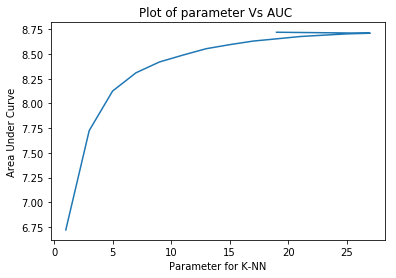

In [164]:
# Plotting graph of auc and parameter

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Area Under Curve")
plt.title("Plot of parameter Vs AUC ")
plt.show()

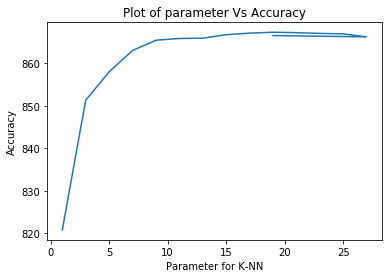

In [165]:
# Plotting graph of acc and parameter

plt.plot(param_list,acc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Accuracy")
plt.title("Plot of parameter Vs Accuracy")
plt.show()

In [170]:
# Training the final model
final_clf = KNeighborsClassifier(n_neighbors=21,algorithm='kd_tree',leaf_size=40)

final_clf.fit(train_tfidf_sent_vectors,Y_train)

predict_y = final_clf.predict(test_tfidf_sent_vectors)
predict_probab = final_clf.predict_proba(test_tfidf_sent_vectors)[:,1] # Returns the class probabality of +ve class only

acc = accuracy_score(Y_test,predict_y,normalize=True)*float(100)
auc = roc_auc_score(Y_test,predict_probab)

print("Accuracy of model with k = 21 is {:.2f}% and auc is {:.2f}".format(acc,auc))

Accuracy of model with k = 21 is 84.26% and auc is 0.50


=========== Confusion matrix ==========


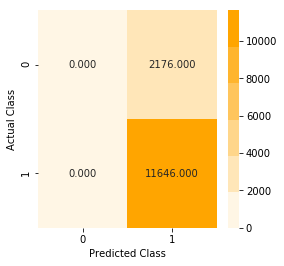

=========== Precision Matrix ==========


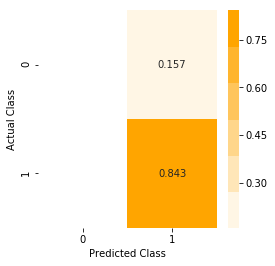

=========== Recall Matrix =============


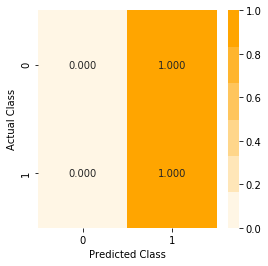

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      2176
          1       0.84      1.00      0.91     11646

avg / total       0.71      0.84      0.77     13822



In [171]:
# Plotting confusion matrix , precision and recall matrix

confusion_matrix_plot(Y_test,predict_y)

# Printing the classification report
print(classification_report(Y_test,predict_y))

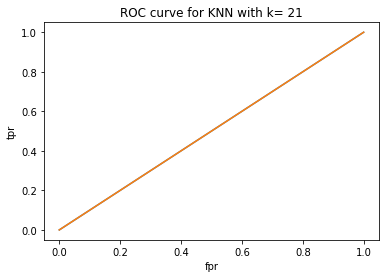

Area under ROC curve is =0.500 


In [172]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(Y_test,predict_y)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve for KNN with k= 21")
plt.show()

# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

<h1>The model that we have trained are performing good on positive class but not that good on negative class</h1>
<h1>Therefore we are trying to analyse positive and negative reviews seperately and remove some most common words.</h1>

In [31]:
# Seperating positive reviews and negative reviews for analysis
positive_review = final[final.Score == 1]
negative_review = final[final.Score == 0]
print(positive_review.shape)
print(negative_review.shape)

(38479, 11)
(7592, 11)


In [32]:
positive_text = positive_review["Cleaned_review"]
negative_text = negative_review["Cleaned_review"]
print(positive_text.shape)
print(negative_text.shape)

(38479,)
(7592,)


In [33]:
pos_word_count = {}
for sent in positive_text:
    for word in sent.split():
        if word not in pos_word_count:
            pos_word_count[word] = 1
        else:
            pos_word_count[word] += 1


In [60]:
import collections
pos_word_counter = collections.Counter(pos_word_count)

words_most_com = []
words_least_com = []

for word,count in pos_word_counter.most_common(200):
    words_most_com.append(word)
    print(word,count)


not 35145
like 15694
good 13981
great 12935
one 11207
taste 10185
tea 9412
love 9368
coffee 9368
would 9174
flavor 9113
product 8827
food 7418
get 6950
really 6542
best 5976
amazon 5860
much 5799
use 5786
also 5730
time 5701
little 5625
price 5289
find 5120
make 5116
chocolate 5111
well 4988
tried 4987
buy 4758
dog 4519
try 4510
better 4448
even 4385
eat 4232
first 3782
sugar 3726
found 3651
cup 3596
drink 3528
bag 3519
used 3499
water 3473
sweet 3406
delicious 3383
free 3368
could 3352
bit 3251
made 3216
day 3166
favorite 3121
recommend 3121
store 3098
two 3065
way 3056
since 3038
bought 3027
mix 3005
nice 2982
think 2921
hot 2868
give 2857
dogs 2848
loves 2834
tastes 2828
treats 2809
many 2783
order 2782
still 2724
every 2711
makes 2703
always 2668
flavors 2659
perfect 2646
add 2642
without 2633
know 2619
easy 2617
box 2605
organic 2597
years 2584
want 2514
right 2495
milk 2485
got 2455
healthy 2443
never 2427
lot 2397
quality 2370
keep 2352
brand 2332
treat 2324
stuff 2304
ever 2297

In [64]:
# Collecting most important positive words together
imp_pos_words = ['good','great','love','loves','loved','best','really','well','better','delicious',
                 'recommend','nice','loves','tastes','treats','perfect','organic','enjoy','definitely','happy','tasty',
                 'wonderful','excellent','pretty']

In [61]:
# Calculating average len of positive reviews
len_sum = 0
for sent in positive_text:
    len_sum += len(sent.split())

print("avg len of reviews",len_sum/38479)

avg len of reviews 37.480235972868314


In [62]:
len_sum = 0
for sent in negative_text:
    len_sum += len(sent.split())

print("avg len of reviews",len_sum/38479)

avg len of reviews 8.557524883702799


In [35]:
neg_word_count = {}
for sent in negative_text:
    for word in sent.split():
        if word not in neg_word_count:
            neg_word_count[word] = 1
        else:
            neg_word_count[word] += 1


In [63]:
import collections
neg_word_counter = collections.Counter(neg_word_count)

for word,count in neg_word_counter.most_common(200):
    print(word,count)

not 12513
like 4189
would 3254
taste 3114
product 2989
one 2498
good 1953
flavor 1869
coffee 1737
food 1557
even 1529
get 1527
tea 1497
amazon 1348
buy 1334
much 1318
really 1307
could 1253
first 1116
tried 1103
dog 1095
time 1092
bought 1073
box 1033
water 1027
better 1002
bad 994
made 987
try 946
eat 933
chocolate 927
also 881
know 875
great 855
bag 837
use 833
love 830
drink 820
two 816
sugar 813
make 808
little 805
thought 799
got 787
way 764
price 751
well 747
used 744
something 740
never 739
ordered 731
still 727
think 722
order 722
tastes 716
find 695
back 663
disappointed 663
cup 663
old 654
money 650
ingredients 631
away 627
brand 626
found 616
products 608
tasted 608
however 601
since 597
give 578
stuff 575
received 570
package 568
different 567
dogs 566
store 566
say 564
many 553
reviews 550
new 547
sweet 539
see 537
sure 531
want 531
hot 526
another 516
company 511
item 510
coconut 507
smell 504
mix 499
ever 494
treats 494
going 492
quality 491
ginger 491
maybe 474
purchase

In [65]:
# Collecting important negative words
neg_imp_words = ['not','like','bad','great','love','disappointed','different','best','waste','waful','horrible',
                 'bitter','jerky','return','unfortunately','worst']

<h1>Observations</h1>
<h2>Clearly we can see that top most occuring word in both positive and negative reviews are "not" and "like".</h2>

In [67]:
# Therefore we are removing "not" word from positive review set and like "from" both datasets.
# And after this we will analyse how does our models perform

cleaned_pos_text = []
for sent in positive_text:
    sentence = []
    s = ""
    for word in sent.split():
        if(word == "not"):
            continue
        if(word in imp_pos_words):
            sentence.append(word)
        else:
            continue
    s = " ".join(e.lower() for e in sentence)
    cleaned_pos_text.append(s.strip())

print(len(cleaned_pos_text))

38479


In [68]:
# For negative reviews
cleaned_neg_text = []
for sent in negative_text:
    sentence = []
    for word in sent.split():
        if(word == "like"):
            continue
        if(word in neg_imp_words):
            sentence = "".join(word.lower())
        else:
            continue
            
    s = " ".join(e.lower() for e in sentence)
    cleaned_neg_text.append(s.strip())
    

print(len(cleaned_neg_text))

7592


In [69]:
# Storing class labels of both positive and negative data points

positive_score = positive_review["Score"]
negative_score = negative_review["Score"]

# Now we will combine positive and negative reviews

review_lst = cleaned_pos_text + cleaned_neg_text

review_label = list(positive_score) + list(negative_score)

In [70]:
# Converting them into dataframe
final_dataset = pd.DataFrame({"Text":review_lst , "Class":review_label})
final_dataset.head()

,Class,Text
0,1,love
1,1,pretty
2,1,great
3,1,love
4,1,really good


In [71]:
from sklearn.model_selection import train_test_split

# Splitting data into train and test
X = final_dataset["Text"]
Y = final_dataset["Class"]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(X_train.shape,X_test.shape)
print(Y_train.value_counts(),Y_test.value_counts())

(32249,) (13822,)
1    26945
0     5304
Name: Class, dtype: int64 1    11534
0     2288
Name: Class, dtype: int64


<h1> Using bag of words</h1>

In [72]:
# BagOfWords for bigrams and unigrams
bow_model = CountVectorizer(ngram_range=(1,2)) # Initializing the model

# vectorizing train dataset
vect_train = bow_model.fit_transform(X_train)

# vectorizing test dataset
vect_test = bow_model.transform(X_test)

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


# Initializing time series splitter
tscv = TimeSeriesSplit(n_splits=10)

# Now we will perform 10 fold cross validation on time split data

acc_list = []
auc_list = []

for k in range(1,30,2):
    # KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=k,algorithm='brute',leaf_size=40)
    i=0
    acc=0.0
    auc=0.0
    for train_index,test_index in tscv.split(vect_train):
        x_train = vect_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = vect_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_y = clf.predict(x_test)
        predict_probab = clf.predict_proba(x_test)[:,1]
        i += 1
        acc += accuracy_score(y_test,predict_y,normalize=True) * float(100)
        auc += roc_auc_score(y_test,predict_probab)
    
    acc_list.append(acc)
    auc_list.append(auc)
    print("Cross Validation Accuracy for k = {:d} is {:.2f}% and auc is {:.2f}".format(k,acc/i,auc/i))


Cross Validation Accuracy for k = 1 is 83.57% and auc is 0.50
Cross Validation Accuracy for k = 3 is 83.57% and auc is 0.95
Cross Validation Accuracy for k = 5 is 89.98% and auc is 0.95
Cross Validation Accuracy for k = 7 is 89.21% and auc is 0.95
Cross Validation Accuracy for k = 9 is 89.93% and auc is 0.95
Cross Validation Accuracy for k = 11 is 91.46% and auc is 0.95
Cross Validation Accuracy for k = 13 is 91.46% and auc is 0.95
Cross Validation Accuracy for k = 15 is 91.46% and auc is 0.95
Cross Validation Accuracy for k = 17 is 91.46% and auc is 0.95
Cross Validation Accuracy for k = 19 is 90.69% and auc is 0.95
Cross Validation Accuracy for k = 21 is 90.68% and auc is 0.95
Cross Validation Accuracy for k = 23 is 91.45% and auc is 0.95
Cross Validation Accuracy for k = 25 is 90.68% and auc is 0.95
Cross Validation Accuracy for k = 27 is 90.68% and auc is 0.95
Cross Validation Accuracy for k = 29 is 91.44% and auc is 0.95


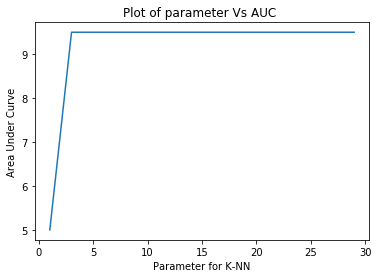

In [74]:
# Plotting graph of auc and parameter

param_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]

plt.plot(param_list,auc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Area Under Curve")
plt.title("Plot of parameter Vs AUC ")
plt.show()

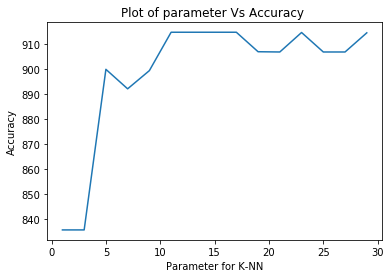

In [75]:
# Plotting graph of accuracy and parameter

plt.plot(param_list,acc_list)
plt.xlabel("Parameter for K-NN")
plt.ylabel("Accuracy")
plt.title("Plot of parameter Vs Accuracy ")
plt.show()

In [77]:
# Training the final model
final_clf = KNeighborsClassifier(n_neighbors=13,algorithm='brute',leaf_size=40)

final_clf.fit(vect_train,Y_train)

predict_y = final_clf.predict(vect_test)
predict_probab = final_clf.predict_proba(vect_test)[:,1] # Returns the class probabality of +ve class only

acc = accuracy_score(Y_test,predict_y,normalize=True)*float(100)
auc = roc_auc_score(Y_test,predict_probab)

print("Accuracy of model with k = 13 is {:.2f}% and auc is {:.2f}".format(acc,auc))

Accuracy of model with k = 13 is 91.49% and auc is 0.95


=========== Confusion matrix ==========


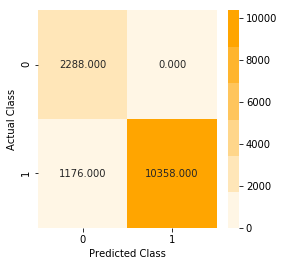

=========== Precision Matrix ==========


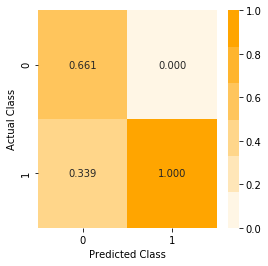

=========== Recall Matrix =============


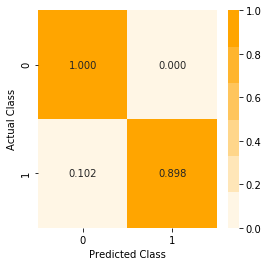

             precision    recall  f1-score   support

          0       0.66      1.00      0.80      2288
          1       1.00      0.90      0.95     11534

avg / total       0.94      0.91      0.92     13822



In [80]:
from sklearn.metrics import classification_report
# Plotting confusion matrix , precision and recall matrix

confusion_matrix_plot(Y_test,predict_y)

# Printing the classification report
print(classification_report(Y_test,predict_y))

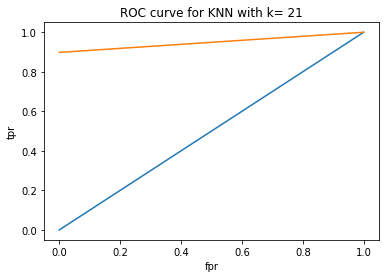

Area under ROC curve is =0.949 


In [81]:
# Plotting ROC Curve
from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(Y_test,predict_y)

plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve for KNN with k= 21")
plt.show()

# Printing area under curve

print("Area under ROC curve is ={:.3f} ".format(roc_auc_score(Y_test,predict_probab)))

<h3>Observation</h3>
<h5> Surpringly the accuracy and area under ROC increased drastically when only most important words were used as features</h5>

# [6] Conclusions

In [95]:
from prettytable import PrettyTable

x = PrettyTable()


x.field_names = ["Model Type","Best K","Accuracy","AUC","Precision","Recall","f1-score"]

x.add_row(["BOW","21","84.05%","0.67","0.80","0.84","0.80"])
x.add_row(["TfIdf","25","84.26%","0.51","0.71","0.84","0.77"])
x.add_row(["Avg W2V","17","87.77","0.87","0.86","0.88","0.86"])
x.add_row(["TfIdf Weighted W2V","21","84.26","0.50","0.71","0.84","0.77"])
x.add_row(["BOW on improved features","13","91.49","0.95","0.94","0.91","0.92"])
print(x)

+--------------------------+--------+----------+------+-----------+--------+----------+
|        Model Type        | Best K | Accuracy | AUC  | Precision | Recall | f1-score |
+--------------------------+--------+----------+------+-----------+--------+----------+
|           BOW            |   21   |  84.05%  | 0.67 |    0.80   |  0.84  |   0.80   |
|          TfIdf           |   25   |  84.26%  | 0.51 |    0.71   |  0.84  |   0.77   |
|         Avg W2V          |   17   |  87.77   | 0.87 |    0.86   |  0.88  |   0.86   |
|    TfIdf Weighted W2V    |   21   |  84.26   | 0.50 |    0.71   |  0.84  |   0.77   |
| BOW on improved features |   13   |  91.49   | 0.95 |    0.94   |  0.91  |   0.92   |
+--------------------------+--------+----------+------+-----------+--------+----------+
